In [1]:
!pip3 install torch torchvision

In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
import matplotlib.pyplot as plt
import numpy as np


In [4]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-02-19 22:18:52--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-02-19 22:18:53--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  11.8MB/s    in 2.8s    

2022-02-19 22:18:56 (11.8 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [5]:
from torchvision.datasets import MNIST
from torchvision import transforms

transforms = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,),(0.5,))
                                 ])

train_set = MNIST('./', download=True, transform = transforms, train=True)

training_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=100, shuffle=True)

In [6]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  print(image.shape)

  image = image.transpose(1, 2, 0)
  print(image.shape)
  image = image * np.array((0.5,)) + np.array((0.5,))
  image = image.clip(0, 1)[:,:,0]

  return image

(1, 28, 28)
(28, 28, 1)
(1, 28, 28)
(28, 28, 1)
(1, 28, 28)
(28, 28, 1)
(1, 28, 28)
(28, 28, 1)


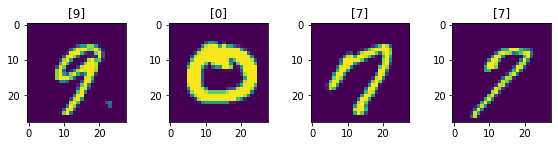

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(4):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))

  ax.set_title([labels[idx].item()])

In [8]:
from torch import nn
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)

  def forward(self, x):
    # 784 -> 128
    x = self.linear1(x)
    x = F.relu(x)
    # 128 -> 64 
    x = self.linear2(x)
    x = F.relu(x)
    # 64 -> 10
    x = self.linear3(x)

    return x

In [9]:
model = Classifier(D_in=784, H1=128, H2=64, D_out=10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
epochs = 12

running_loss_history = []
running_correct_history = []

for e in range(epochs):
  running_loss = 0.0
  running_correct = 0.0
  for inputs, labels in training_loader:
    # 28x28 image into 784 values
    inputs = inputs.view(inputs.shape[0],-1)
    
    outputs = model(inputs)
    # [10 digits]

    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    # 1,28,28

    _, preds = torch.max(outputs, 1)
    running_correct+=torch.sum(preds == labels.data)

    running_loss += loss
  else:
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_correct.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)
    print("training loss {:.4f}, Accuracy {:.4f}".format(epoch_loss,epoch_acc))



training loss 0.3947, Accuracy 87.7133
training loss 0.2337, Accuracy 93.0367
training loss 0.2133, Accuracy 93.6417
training loss 0.2014, Accuracy 94.1017
training loss 0.1881, Accuracy 94.5400
training loss 0.1921, Accuracy 94.4600
training loss 0.1835, Accuracy 94.7767
training loss 0.1755, Accuracy 95.0900
training loss 0.1776, Accuracy 95.0900
training loss 0.1773, Accuracy 95.0250
training loss 0.1676, Accuracy 95.4000
training loss 0.1693, Accuracy 95.3083


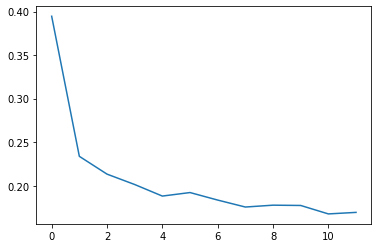

In [24]:
lss = [loss.detach() for loss in running_loss_history]
plt.plot(lss, label='training_loss')